# Prepare

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr
import datetime
import time
import itertools
import pickle

from VariationalNC.utils import *
from VariationalNC.train import *
from VariationalNC.Variational_layers import VariationalLinear, VariationalConv2d
from VariationalNC.Variational_utils import variational_estimator, ScaleMixtureGaussian
import VariationalNC.activation_max_utils as amu

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

# for plot figures
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
class VanillaCNN(nn.Module):
    def __init__(self,numoffea=48):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=22*50 #size of feature
        self.numofneuron=161 #number of neurons
        #
        self.conv1 = nn.Conv2d(2,48,kernel_size=9,stride=1)#24,23*23
        stdv = 1. / np.sqrt(1*9*9)
        self.conv1.weight.data.uniform_(-stdv, stdv)
        self.conv1.bias.data.uniform_(-stdv, stdv)
        #
        self.conv2=nn.Conv2d(48,self.numoffea,kernel_size=7,stride=1)#48,17*17
        stdv = 1. / np.sqrt(48*7*7)
        self.conv2.weight.data.uniform_(-stdv, stdv)
        self.conv2.bias.data.uniform_(-stdv, stdv)
        #
        self.fc1 = nn.Linear(self.numoffea*self.sizeoffea, self.numofneuron)
        stdv = 1. / np.sqrt(self.numoffea*self.sizeoffea)
        self.fc1.weight.data.uniform_(-stdv, stdv)
        self.fc1.bias.data.uniform_(-stdv, stdv)
    def forward(self, x):
        encoded = F.relu(self.conv1(x))#24,23*23
        encoded = F.relu(self.conv2(encoded))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded)) #use exp instead of relu
        return encoded
    
@variational_estimator
class VariationalCNN(nn.Module):
    def __init__(self,numoffea=48,PI=0.5, SIGMA_1=1, SIGMA_2=0.00247875):
        super().__init__()
        self.numoffea=numoffea #number of features
        self.sizeoffea=22*50 #size of feature
        self.numofneuron=161 #number of neurons
        self.conv1=VariationalConv2d(2,48,kernel_size=(9,9),stride=(1,1),padding=(0,0),PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)#24,23*23
        self.conv2=VariationalConv2d(48,self.numoffea,kernel_size=(7,7),stride=(1,1),padding=(0,0),PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)#48,17*17
        self.fc1  =VariationalLinear(self.numoffea*self.sizeoffea,self.numofneuron,PI=PI, SIGMA_1=SIGMA_1, SIGMA_2=SIGMA_2)
    def forward(self, x, sampleFlag=False):
        encoded = F.relu(self.conv1(x, sampleFlag))#24,23*23
        encoded = F.relu(self.conv2(encoded, sampleFlag))#48,17*17
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded, sampleFlag)) #use exp instead of relu
        return encoded

In [3]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
train_std = torch.from_numpy(np.array([0.23363489, 0.24817178])[None,:,None,None]).float()

In [4]:
def act_max_pack(
    tempmodel, # model
    train_std, # torch.tensor, from the training data
    unit,         # neuron id
    inputseed = 1,  # for input_img
    sampleFlag=False, # for variational model
    sampleseed=1,     # for variational model
    device=device_cpu,    # only test cpu for now
):
    """
    Activation max, packed function.
    Output: torch.tensor, with a shape of (1, c, h, w), with a std equals to train_std
    """
    tempmodel = tempmodel.to(device)  
    for param in tempmodel.parameters():
        param.requires_grad = False
    tempmodel = tempmodel.eval()
    # for param in tempmodel.parameters():
    #     print (param)
    
    # input_img, should have a shape of (1, c, h, w)
    torch.manual_seed(inputseed)    # reproducible
    input_img = torch.randn(1, 2, 36, 64) * train_std
    
    # model.fc1
    activation_dictionary = {}
    layer_name = 'fc1'
    tempmodel.fc1.register_forward_hook(amu.layer_hook(activation_dictionary, layer_name))

    # config for activation maximization
    steps = 100                 # perform 100 iterations
    # unit = 95                  # flamingo class of Imagenet
    alpha = torch.tensor(10)   # learning rate (step size) 
    verbose = False              # print activation every step
    L2_Decay = True             # enable L2 decay regularizer
    Gaussian_Blur = True        # enable Gaussian regularizer
    Norm_Crop = True            # enable norm regularizer
    Contrib_Crop = True         # enable contribution regularizer
    # sampleFlag=False          # for variational model
    # sampleseed=4              # for variational model
    
    output = amu.act_max(network=tempmodel,
                input=input_img,
                layer_activation=activation_dictionary,
                layer_name=layer_name,
                unit=unit,
                steps=steps,
                alpha=alpha,
                verbose=verbose,
                L2_Decay=L2_Decay,
                Gaussian_Blur=Gaussian_Blur,
                Norm_Crop=Norm_Crop,
                Contrib_Crop=Contrib_Crop,
                sampleFlag=sampleFlag,
                sampleseed=sampleseed,
                )
    
    # keep the mean and the std consistent with training data (mean is equal to zeros)
    # output image has the same shape with the input
    output = output - torch.mean(output, dim=(2,3), keepdims=True)
    output = output/torch.std(output, dim=(2,3), keepdims=True)*train_std
    # print (torch.std(output))
    return output


In [5]:
#https://stats.stackexchange.com/questions/65831/permutation-test-comparing-a-single-sample-against-a-mean
#https://netneurotools.readthedocs.io/en/latest/_modules/netneurotools/stats.html#permtest_1samp
def oneSamp_perm_test(xs, popmean, nmc, randomseed,alternative='two-sided'):
    """
    Generates two-tailed p-value for hypothesis of whether `xs` differs from
    `popmean` using permutation tests
    """
    n, k = len(xs), 0
    # center `xs` around `popmean` and calculate original mean
    zeroed = xs - popmean
    true_mean= np.mean(zeroed)
    abs_mean = np.abs(true_mean)
    for j in range(nmc):
        np.random.seed(randomseed+j)
        flipped = zeroed * np.random.choice([-1, 1], size=zeroed.shape)  # sign flip
        #k += abs_mean <= np.abs(np.mean(flipped))
        if alternative=='two-sided':
            k += abs_mean <= np.abs(np.mean(flipped))
        elif alternative=='greater':
            k += true_mean <= np.mean(flipped)
        elif alternative=='less':
            k += true_mean >= np.mean(flipped)
    return k / nmc

# one unit

In [12]:
# one model-VanillaCNN, one unit, one inputseed
tempmodel= VanillaCNN()   #with regularization
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))
# tempmodels=['VariationalCNN'] 
# model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
# tempmodel = globals()[tempmodels[0]](**model_parameters)
# torch.manual_seed(1)    # reproducible
# torch.cuda.manual_seed(1)
# tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))

unit = 95
inputseed = 1
sampleFlag = False
sampleseed = 1
output = act_max_pack(
    tempmodel = tempmodel, # model
    train_std = train_std, # torch.tensor, from the training data
    unit = unit,             # neuron id
    inputseed = inputseed,   # for input_img
    sampleFlag = sampleFlag,      # for variational model
    sampleseed = sampleseed,      # for variational model
)
outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

# test activation
tempmodel= VanillaCNN()   #with regularization
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
tempmodel = tempmodel.to(device_cpu) 
tempmodel = tempmodel.eval()
outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
# simple plot
# plt.imshow(output.cpu().data.numpy()[0,0])

outs.shape: (1, 161). Neuron 95 activation: 5.514772891998291
Test activation: outs.shape: (1, 161). Neuron 95 activation: 9.366104125976562


outs.shape: (1, 161). Neuron 95 activation: 8.139802932739258
Test activation: outs.shape: (1, 161). Neuron 95 activation: 11.464073181152344


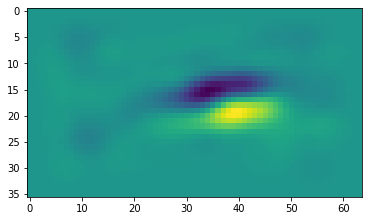

In [21]:
# one model-VariationalCNN-sampleFlag=False, one unit, one inputseed
# tempmodel= VanillaCNN()   #with regularization
# tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))

unit = 95
inputseed = 1
sampleFlag = False
sampleseed = 1
output = act_max_pack(
    tempmodel = tempmodel, # model
    train_std = train_std, # torch.tensor, from the training data
    unit = unit,             # neuron id
    inputseed = inputseed,   # for input_img
    sampleFlag = sampleFlag,      # for variational model
    sampleseed = sampleseed,      # for variational model
)
outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')

# test activation
tempmodel= VanillaCNN()   #with regularization
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
tempmodel = tempmodel.to(device_cpu) 
tempmodel = tempmodel.eval()
outs = np.log(tempmodel( output ).cpu().data.numpy()) # cancel out the last layer - exp layer
print (f'Test activation: outs.shape: {outs.shape}. Neuron {unit} activation: {outs[0, unit]}')
# simple plot
plt.imshow(output.cpu().data.numpy()[0,0])

## Variational-sampleFlag=True

In [32]:
# one model-Variational-sampleFlag=True, one unit, one inputseed
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))

unit = 95
inputseed = 1
sampleFlag = True
sampleseeds = np.arange(100).tolist()
tempoutputs = []
for ii, sampleseed in enumerate(sampleseeds):
    tempoutput = act_max_pack(
        tempmodel = tempmodel, # model
        train_std = train_std, # torch.tensor, from the training data
        unit = unit,             # neuron id
        inputseed = inputseed,   # for input_img
        sampleFlag = sampleFlag,      # for variational model
        sampleseed = sampleseed,      # for variational model
    )
    tempoutputs.append(tempoutput.cpu().data.numpy())

tempoutputs = np.array(tempoutputs)
print (f'tempoutputs.shape: {tempoutputs.shape}')

tempoutputs.shape: (100, 1, 2, 36, 64)


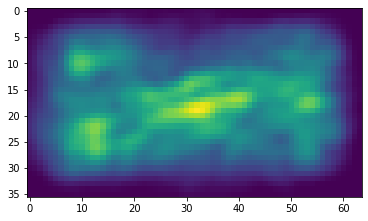

In [33]:
plt.imshow(np.std(tempoutputs, axis=0, ddof=1)[0,0])

(100, 1, 2, 36, 64)


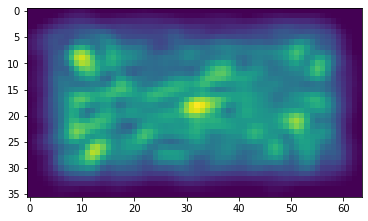

In [16]:
i=1
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
plt.imshow(np.std(RF_fl_np, axis=0, ddof=1)[0,0])

(100, 1, 2, 36, 64)


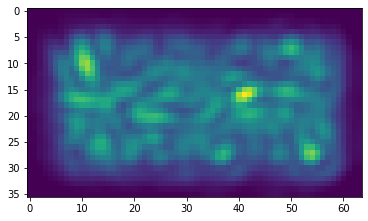

In [17]:
i=2
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
plt.imshow(np.std(RF_fl_np, axis=0, ddof=1)[0,0])

(100, 1, 2, 36, 64)


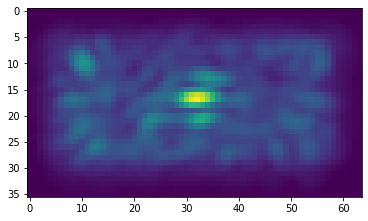

In [14]:
i=3
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
plt.imshow(np.std(RF_fl_np, axis=0, ddof=1)[0,0])

(100, 1, 2, 36, 64)


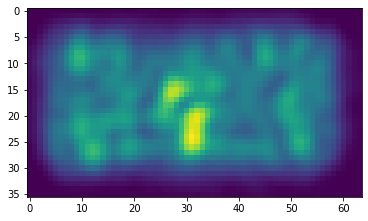

In [19]:
i=3
RF_fl_np=np.load('out_20220423/trainnum_1_activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
plt.imshow(np.std(RF_fl_np, axis=0, ddof=1)[0,0])

(100, 1, 2, 36, 64)


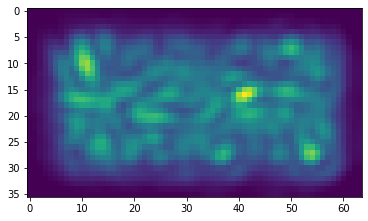

In [18]:
i=2
RF_fl_np=np.load('out_20220423/activation-max-example-neuron95-outputs_seed_'+str(i)+'_vcnn_sampleflag_true_Franke2021.npy')
print(RF_fl_np.shape)
plt.imshow(np.std(RF_fl_np, axis=0, ddof=1)[0,0])

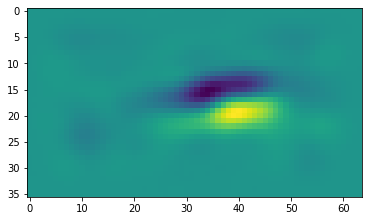

In [34]:
plt.imshow(np.mean(tempoutputs, axis=0)[0,0])

In [36]:
#np.save('out_20220423/YQactivation-max-outputs-manysamples-VariationalCNN_Franke2021.npy', tempoutputs)

# multiple units

## vanilla

In [17]:
# one model, all neurons, 5 inputseeds
tempmodel= VanillaCNN()   #with regularization
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))

units = np.arange(161).tolist()
inputseeds = np.arange(1,6).tolist()
sampleFlag = False
sampleseed = 1

# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

outputs = [] # numpy array
acts = np.ones(len(units)) * (-np.inf)
for ii,unit in enumerate(units):
    tempoutputs = []
    tempacts = np.ones(len(inputseeds)) * (-np.inf)
    for jj,inputseed in enumerate(inputseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput)
        tempacts[jj] = np.log(tempmodel( tempoutput ).cpu().data.numpy())[0, unit]
    # selected the output image with largest activations based on original tempmodel
    tempbestoutput = tempoutputs[np.argmax(tempacts)] 
    outputs.append(tempbestoutput.cpu().data.numpy())
    
    # test activation
    acts[ii] = np.log(testmodel( tempbestoutput ).cpu().data.numpy())[0, unit] # cancel out the last layer - exp layer

outputs_rcnn = np.array(outputs)
acts_rcnn = np.copy(acts)

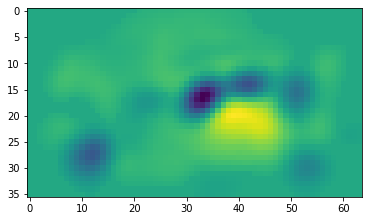

In [20]:
plt.imshow(outputs_rcnn[95][0,0])

In [18]:
acts_rcnn[95]

9.366104125976562

In [37]:
#np.save('out_20220423/YQactivation-max-many-neurons-outputs_rcnn_Franke2021.npy', outputs_rcnn)
#np.save('out_20220423/YQactivation-max-many-neurons-acts_rcnn_Franke2021.npy', acts_rcnn)

## variation-sampleFlag=False

In [22]:
# one model-variation-sampleFlag=False, all neurons, 5 inputseeds
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
torch.manual_seed(1)    # reproducible
torch.cuda.manual_seed(1)
tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__seed_0.pth'))

units = np.arange(161).tolist()
inputseeds = np.arange(1,6).tolist()
sampleFlag = False
sampleseed = 1

# test model
testmodel= VanillaCNN()   #with regularization
testmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VanillaCNN_trainnum_4_Franke2021Data_trainN__seed_5.pth'))
testmodel = testmodel.to(device_cpu) 
testmodel = testmodel.eval()

outputs = [] # numpy array
acts = np.ones(len(units)) * (-np.inf)
for ii,unit in enumerate(units):
    tempoutputs = []
    tempacts = np.ones(len(inputseeds)) * (-np.inf)
    for jj,inputseed in enumerate(inputseeds):
        tempoutput = act_max_pack(
            tempmodel = tempmodel, # model
            train_std = train_std, # torch.tensor, from the training data
            unit = unit,             # neuron id
            inputseed = inputseed,   # for input_img
            sampleFlag = sampleFlag,      # for variational model
            sampleseed = sampleseed,      # for variational model
        )
        tempoutputs.append(tempoutput)
        tempacts[jj] = np.log(tempmodel( tempoutput ).cpu().data.numpy())[0, unit]
    # selected the output image with largest activations based on original tempmodel
    tempbestoutput = tempoutputs[np.argmax(tempacts)] 
    outputs.append(tempbestoutput.cpu().data.numpy())
    
    # test activation
    acts[ii] = np.log(testmodel( tempbestoutput ).cpu().data.numpy())[0, unit] # cancel out the last layer - exp layer

outputs_vcnn = np.array(outputs)
acts_vcnn = np.copy(acts)

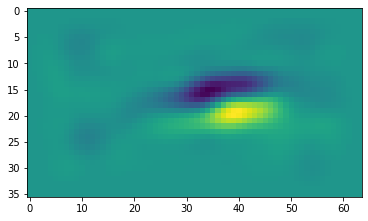

In [23]:
plt.imshow(outputs_vcnn[95][0,0])

# try

### plosCBrebuttal

#### plot 6 neuon 

In [8]:
tempact95=np.load('out_20220423/MEIinput_activation-neuron95.npy')
tempact123=np.load('out_20220423/MEIinput_activation-neuron123.npy')
tempact106=np.load('out_20220423/MEIinput_activation-neuron106.npy')
tempact61=np.load('out_20220423/MEIinput_activation-neuron61.npy')
tempact52=np.load('out_20220423/MEIinput_activation-neuron52.npy')
tempact101=np.load('out_20220423/MEIinput_activation-neuron101.npy')

In [9]:
print(tempact95.shape)

(100, 1, 161)


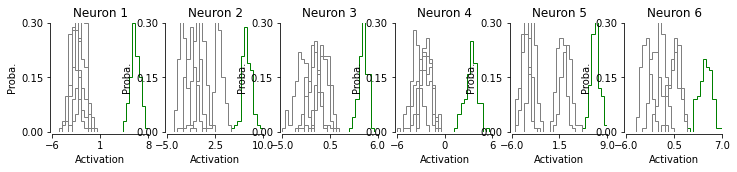

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=6,figsize=(12,2))

weights = np.ones_like(tempact95[:,:,95].flatten())/float(len(tempact95[:,:,95].flatten()))
vmin, vmax = -6,8 #np.min(signal_cor_values), np.max(signal_cor_values)
axes[0].hist(tempact95[:,:,95].flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[0].hist(tempact123[:,:,95].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[0].hist(tempact106[:,:,95].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[0].hist(tempact61[:,:,95].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[0].hist(tempact52[:,:,95].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[0].hist(tempact101[:,:,95].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[0].set_xlabel('Activation')
axes[0].set_ylabel('Proba.')
axes[0].set_xlim(-6,8)
axes[0].set_xticks([-6,1,8])
axes[0].set_ylim(0,0.3)
axes[0].set_yticks([0,0.15,0.3])
axes[0].set_title('Neuron 1') 
adjust_spines(axes[0], ['left', 'bottom'])


weights = np.ones_like(tempact123[:,:,123].flatten())/float(len(tempact123[:,:,123].flatten()))
vmin, vmax = -5,10 #np.min(signal_cor_values), np.max(signal_cor_values)
axes[1].hist(tempact123[:,:,123].flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[1].hist(tempact95[:,:,123].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[1].hist(tempact106[:,:,123].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[1].hist(tempact61[:,:,123].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[1].hist(tempact52[:,:,123].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[1].hist(tempact101[:,:,123].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[1].set_xlabel('Activation')
axes[1].set_ylabel('Proba.')
axes[1].set_xlim(-5,10)
axes[1].set_xticks([-5,2.5,10])
axes[1].set_ylim(0,0.3)
axes[1].set_yticks([0,0.15,0.3])
axes[1].set_title('Neuron 2') 
adjust_spines(axes[1], ['left', 'bottom'])



weights = np.ones_like(tempact106[:,:,106].flatten())/float(len(tempact106[:,:,106].flatten()))
vmin, vmax = -5,6 #np.min(signal_cor_values), np.max(signal_cor_values)
axes[2].hist(tempact106[:,:,106].flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[2].hist(tempact95[:,:,106].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[2].hist(tempact123[:,:,106].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[2].hist(tempact61[:,:,106].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[2].hist(tempact52[:,:,106].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[2].hist(tempact101[:,:,106].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[2].set_ylabel('Proba.')
axes[2].set_xlim(-5,6)
axes[2].set_xticks([-5,0.5,6])
axes[2].set_ylim(0,0.3)
axes[2].set_yticks([0,0.15,0.3])
axes[2].set_title('Neuron 3') 
adjust_spines(axes[2], ['left', 'bottom'])


weights = np.ones_like(tempact61[:,:,61].flatten())/float(len(tempact61[:,:,61].flatten()))
vmin, vmax = -6,6 #np.min(signal_cor_values), np.max(signal_cor_values)
axes[3].hist(tempact61[:,:,61].flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[3].hist(tempact95[:,:,61].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[3].hist(tempact123[:,:,61].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[3].hist(tempact106[:,:,61].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[3].hist(tempact52[:,:,61].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[3].hist(tempact101[:,:,61].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[3].set_xlabel('Activation')
axes[3].set_ylabel('Proba.')
axes[3].set_xlim(-6,6)
axes[3].set_xticks([-6,0,6])
axes[3].set_ylim(0,0.3)
axes[3].set_yticks([0,0.15,0.3])
axes[3].set_title('Neuron 4') 
adjust_spines(axes[3], ['left', 'bottom'])



weights = np.ones_like(tempact52[:,:,52].flatten())/float(len(tempact52[:,:,52].flatten()))
vmin, vmax = -6,9 #np.min(signal_cor_values), np.max(signal_cor_values)
axes[4].hist(tempact52[:,:,52].flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[4].hist(tempact95[:,:,52].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[4].hist(tempact123[:,:,52].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[4].hist(tempact106[:,:,52].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[4].hist(tempact61[:,:,52].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[4].hist(tempact101[:,:,52].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[4].set_xlabel('Activation')
axes[4].set_ylabel('Proba.')
axes[4].set_xlim(-6,9)
axes[4].set_xticks([-6,1.5,9])
axes[4].set_ylim(0,0.3)
axes[4].set_yticks([0,0.15,0.3])
axes[4].set_title('Neuron 5') 
adjust_spines(axes[4], ['left', 'bottom'])


weights = np.ones_like(tempact101[:,:,101].flatten())/float(len(tempact101[:,:,101].flatten()))
vmin, vmax = -6,7 #np.min(signal_cor_values), np.max(signal_cor_values)
axes[5].hist(tempact101[:,:,101].flatten(), bins=30,edgecolor='g', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[5].hist(tempact95[:,:,101].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[5].hist(tempact123[:,:,101].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[5].hist(tempact106[:,:,101].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[5].hist(tempact61[:,:,101].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[5].hist(tempact52[:,:,101].flatten(), bins=30,edgecolor='gray', histtype='step', 
          range=[vmin,vmax], weights=weights,fill=False)
axes[5].set_xlabel('Activation')
axes[5].set_ylabel('Proba.')
axes[5].set_xlim(-6,7)
axes[5].set_xticks([-6,0.5,7])
axes[5].set_ylim(0,0.3)
axes[5].set_yticks([0,0.15,0.3])
axes[5].set_title('Neuron 6') 
adjust_spines(axes[5], ['left', 'bottom'])


#fig.savefig('out_result_20220423/try_3.svg')

#### choose the neurons with response CC>0.5

In [6]:
with open('Data_Franke_et_al_2021/static25311-10-26-meis_neuron_good_ind2.pkl', 'rb') as ff:
    meis_neuron_good_ind2 = pickle.load(ff)

print(meis_neuron_good_ind2[str(95)].shape)

(1, 2, 36, 64)


In [7]:
empty_values = [key for key, value in meis_neuron_good_ind2.items() if value is None]
print(empty_values)

['13', '22', '26', '27', '29', '30', '44', '47', '62', '75', '79', '80', '83', '125', '130', '136', '138', '139', '142', '144', '145', '148', '151', '154', '156', '158']


In [8]:
testccs_VCNN=np.load('out_20220423/Modelcalibration_Prediction_CC_against_prediction_var_testccs_VCNN.npy')
print (testccs_VCNN.shape)

(10, 161)


In [9]:
thresh = 0.5
seed_id=0
neuron_qualified=[]
for i in range(161):
    if str(i) not in empty_values:
        if testccs_VCNN[seed_id,i]>=thresh:
            neuron_qualified.append(i)     

In [10]:
print(neuron_qualified)

[14, 20, 23, 28, 35, 41, 48, 49, 50, 52, 54, 55, 56, 61, 77, 78, 91, 95, 97, 98, 101, 103, 104, 106, 110, 113, 114, 122, 123, 126, 128, 129, 131, 132, 133, 141, 146, 147, 153, 160]


In [11]:
len(neuron_qualified)

40

In [12]:
train_std = np.array([0.23363489, 0.24817178])[None,:,None,None]

In [13]:
tempmodels=['VariationalCNN'] 
model_parameters = {'PI': 0.5, 'SIGMA_1': 1, 'SIGMA_2': 0.00247875}
tempmodel = globals()[tempmodels[0]](**model_parameters)
neuron_1_response=np.zeros([len(neuron_qualified), 100, 1])
neuron_60_response=np.zeros([len(neuron_qualified), len(neuron_qualified)-1, 100, 1])
for i in range(len(neuron_qualified)):
    temp=meis_neuron_good_ind2[str(neuron_qualified[i])]
    tempmei=temp-np.mean(temp, axis=(0,2,3), keepdims=True)
    tempmei=tempmei/np.std(tempmei, axis=(0,2,3), keepdims=True)*train_std

    torch.manual_seed(1)
    torch.cuda.manual_seed(1)
    tempmodel.load_state_dict(torch.load('./out_2YQ_Franke2021/VariationalCNN_trainnum_4_Franke2021Data_trainN__'+'seed_'+str(0)+'.pth'))
    tempmodel = tempmodel.to(device_cpu) 
    tempmodel = tempmodel.eval()

    tempact=np.zeros((100,1,161))
    for j in range(100):
        tempact[j] = np.log(tempmodel(torch.from_numpy(tempmei).float(),sampleFlag=True).cpu().data.numpy()) # cancel out the last layer - exp layer
    count=0
    for k in neuron_qualified:
        if k == neuron_qualified[i]:
            neuron_1_response[i]=tempact[:,:,k]
        else:
            neuron_60_response[i][count]=tempact[:,:,k]
            count+=1
np.save('out_20220423/MEIinput_activation_seed1_61neurons_1response2.npy', neuron_1_response)
np.save('out_20220423/MEIinput_activation_seed1_61neurons_60response2.npy', neuron_60_response)

#### permutation test and plot

In [50]:
neuron_1_response=np.load('out_20220423/MEIinput_activation_seed1_61neurons_1response2.npy')
neuron_60_response=np.load('out_20220423/MEIinput_activation_seed1_61neurons_60response2.npy')
print(f'Shape of test responses: {neuron_1_response.shape}')
print(f'Shape of control responses: {neuron_60_response.shape}')

Shape of test responses: (40, 100, 1)
Shape of control responses: (40, 39, 100, 1)


In [51]:
# mean_each_stimulus = np.mean(neuron_60_response, axis=(2,3))
# sti_ind_most = np.argmax(mean_each_stimulus, axis=1)
# print (sti_ind_most)
# neuron_60_response_most = np.zeros_like(neuron_1_response)
# for ii in range(len(neuron_60_response_most)):
#     neuron_60_response_most[ii] = neuron_60_response[ii, sti_ind_most[ii]]

In [52]:
# #permutation test
# #https://stackoverflow.com/questions/24795535/pythons-implementation-of-permutation-test-with-permutation-number-as-input
# #permutation test using monte-carlo method
# def perm_test(xs, ys, nmc, randomseed):
#     n, k = len(xs), 0
#     diff = np.abs(np.mean(xs) - np.mean(ys))
#     zs = np.concatenate([xs, ys])
#     for j in range(nmc):
#         np.random.seed(randomseed+j)
#         np.random.shuffle(zs)
#         k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
#     return k / nmc
# def perm_test_group(list_of_array,nmc=10000,randomseed=66):
#     perm_res=[]
#     for ii in np.arange(len(list_of_array)):
#         for jj in np.arange(ii+1,len(list_of_array)):
#             temp=perm_test(list_of_array[ii], list_of_array[jj], nmc, (ii*jj+jj+randomseed)*nmc)
#             perm_res.append(temp)
#     return perm_res
# #
# pvalues = -np.ones(len(neuron_1_response))
# for ii in range(len(pvalues)):
#     pvalues[ii] = perm_test(neuron_1_response[ii].flatten(),neuron_60_response[ii].flatten(),nmc=10000,randomseed=66)

In [53]:
# fig, ax = plt.subplots(figsize=(3,3))
# ax.scatter(np.mean(neuron_1_response, axis=(1,2)),
#            np.mean(neuron_60_response_most, axis=(1,2)),  marker='o', color='g')
# ax.plot([0,10], [0,10], color='k',linestyle='--')
# ax.set_xlim(0,10)
# ax.set_ylim(0,10)

In [54]:
response_2d = -10*np.ones((len(neuron_1_response), len(neuron_1_response)))
for ii in range(len(response_2d)): # for each neuron
    response_2d[ii] = np.insert(np.mean(neuron_60_response[ii], axis=(1,2)), ii, np.mean(neuron_1_response[ii]))
response_2d = response_2d/np.max(response_2d, axis=1, keepdims=True)

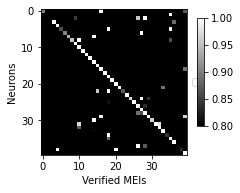

In [90]:
fig, ax = plt.subplots(figsize=(3,3))
# cax = fig.add_axes([1.01, 0.2, 0.05, 0.5])
im = ax.imshow(response_2d, vmin=0.8, vmax=1, cmap='gray')
ax.set_xlabel('Verified MEIs')
ax.set_ylabel('Neurons')
ax.set_xticks([0, 10, 20, 30])
ax.set_yticks([0, 10, 20, 30])
# fig.colorbar(im, cax=cax, orientation='vertical')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.3, 0.03, 0.5])
fig.colorbar(im, cax=cbar_ax)
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
# fig.savefig('out_result_20220423/try_normalized_response_matrix.svg',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [84]:
len(np.where(np.diag(response_2d)>=0.8)[0])

37

(array([  6.,  14.,  32., 140., 337., 470., 305., 162.,  46.,  88.]),
 array([-1.69637775, -1.42673997, -1.1571022 , -0.88746442, -0.61782665,
        -0.34818887, -0.0785511 ,  0.19108668,  0.46072445,  0.73036223,
         1.        ]),
 <BarContainer object of 10 artists>)

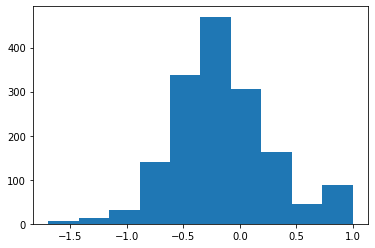

In [57]:
plt.hist(response_2d.flatten())